In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import calendar
plt.style.use('ggplot')
import seaborn as sns
import datetime
pd.set_option('display.max_columns', 500)
from scipy.stats import ttest_ind,boxcox,chi2_contingency
import os, pickle
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from state_abbr import states as states_dict

FIG_SIZE = (15,5)

### Load data

In [2]:
data_size = 'small' # ['small','medium','large']
flights = pd.read_csv("flights_{0}.csv".format(data_size)) 
flights["Date"] = pd.to_datetime(flights["Date"]) # format date
any_nans = flights.isnull().values.any()
n,m = flights.shape
print("n observations = {0:,}. n features = {1}. Any NANs = {2}".format(n,m,any_nans))

n observations = 100,000. n features = 19. Any NANs = False


### Get year, month of flight and add full departure state name

In [3]:
flights.insert(loc=1,column="month",value=pd.DatetimeIndex(flights['Date']).month)
flights.insert(loc=1,column="year",value=pd.DatetimeIndex(flights['Date']).year)
flights['Departure_State_Full'] = flights.Departure_State.apply(lambda state: states_dict[state])
flights[["Date","year","month",'Departure_State_Full','Departure_State']].sample(5)

,Date,year,month,Departure_State_Full,Departure_State
753,2010-06-13,2010,6,Arizona,AZ
86386,2011-12-04,2011,12,Texas,TX
39166,2007-06-20,2007,6,Maryland,MD
84245,2008-02-08,2008,2,Texas,TX
32930,2007-06-26,2007,6,Indiana,IN


### What is the trend over time in number of flights?

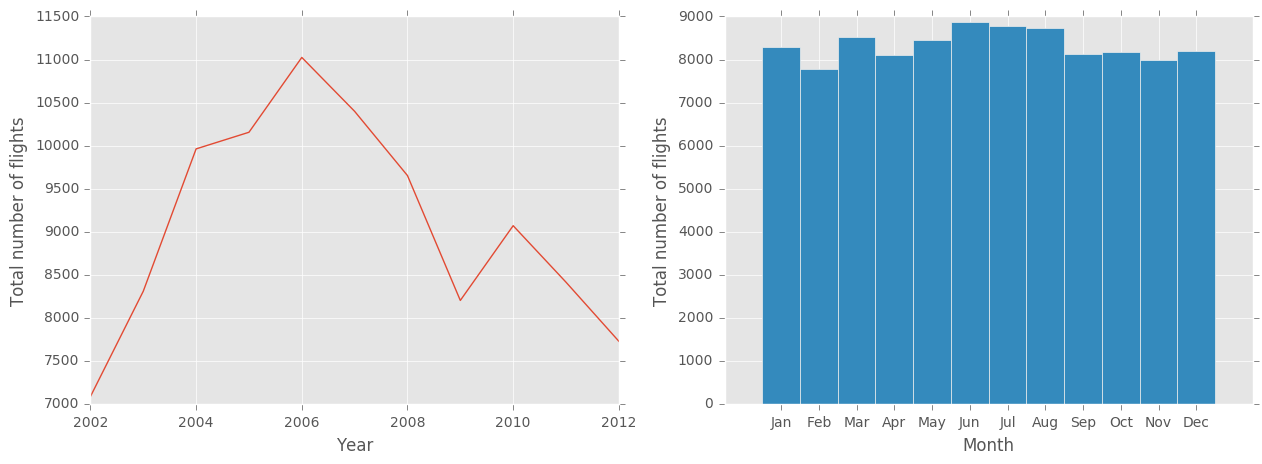

In [4]:
flights_by_year = flights.groupby('year').size()
flights_by_month = flights.groupby('month').size()
f, (ax1, ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
months = flights_by_month.index 
months_names = [calendar.month_abbr[mon] for mon in months]
width=1.0
ax1.plot(flights_by_year); ax1.set_xlabel("Year"); ax1.set_ylabel("Total number of flights")
ax2.bar(months,flights_by_month,width=width); ax2.set_xticklabels(months_names); ax2.set_xticks(months + width / 2);
ax2.set_xlabel("Month"); ax2.set_ylabel("Total number of flights")
plt.show()

* Flights by year shows decrease in total annual flights after 2006. Possibly due to financial crash.
* Flights by month differences might possibly be related to US holidays.

### Departure traffic by state

In [5]:
state_dep_counts = pd.DataFrame(flights["Departure_State"].value_counts())
data = [ dict(type='choropleth',  autocolorscale = True, #colorscale = scl,
        locations = state_dep_counts.index,
        z = state_dep_counts['Departure_State'].astype(float),
        locationmode = 'USA-states',
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "Departure total traffic")
    ) ]

layout = dict(title = 'Departure total traffic',
        geo = dict(scope='usa',projection=dict( type='albers usa' ),showlakes = True,lakecolor = 'rgb(255, 255, 255)'),
    )
fig = dict( data=data, layout=layout )
iplot(data)  

# <center>Delay times?</center>

[Top reasons for delays](http://www.mro-network.com/maintenance-repair-overhaul/top-5-reasons-flight-delays/gallery?slide=5)
* late arriving aircraft - can't obtain this feature as we don't have a unique plane id in dataset.
* air carrier delays - no info
* heavy traffic volume - can model this
* extreme weather - can model this
* security lines - no info.

### Delays are highly skewed (focus on departure delays as opposed to arrivals)

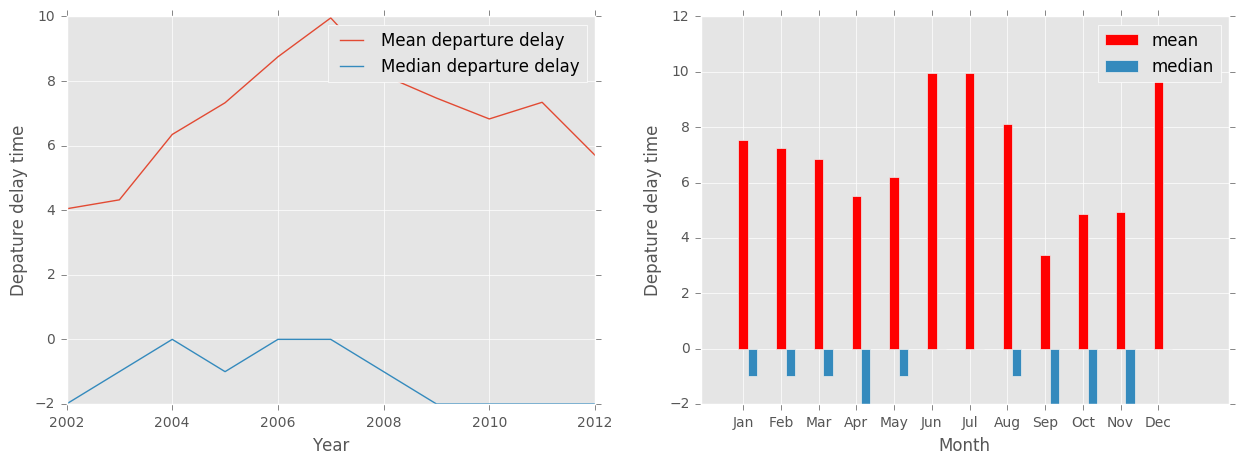

In [6]:
departure_delay_year = flights[["Departure_delay","year"]].groupby("year").agg(["mean","median"]) 
departure_delay_month = flights[["Departure_delay","month"]].groupby('month').agg(["mean","median"])
f, (ax1, ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
ax1.plot(departure_delay_year)
ax1.legend(("Mean departure delay","Median departure delay"))
ax1.set_ylabel("Depature delay time"); ax1.set_xlabel("Year")

width = 0.25
ax2.bar(months,departure_delay_month["Departure_delay"]["mean"].values,width=width,color='red');
ax2.bar(months+width,departure_delay_month["Departure_delay"]["median"].values,width=width);
ax2.set_xticklabels(months_names); ax2.set_xticks(months + width / 2);
ax2.set_xlabel("Month"); ax2.set_ylabel("Depature delay time")
ax2.legend(("mean","median"))
plt.show()

* Delays seem to be correlated with overall traffic. E.g. delays are more likely to be long in high traffic months such as june, july as well as high traffic years e.g. 2006. 
* Delays also very higher in winter months as expected.
* Mean >> Median implying positivley skewed delays. I.e there are few very long delays

### Let's clip any negative departure delays less than the 1% quantile. These are not really 'delays'.

In [7]:
quantile_lower_clip = np.percentile(flights['Departure_delay'],1)
flights['Departure_delay'] = flights['Departure_delay'].clip_lower(quantile_lower_clip)

## <center>Airline descriptions</center>

In [8]:
def stat_summary(group): # summary statistics for pandas groupby
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
flights['Departure_delay'].groupby(flights['Airline']).apply(stat_summary).unstack()

,count,max,mean,min
Airline,,,,
9E,700.0,227.0,5.340000,-12.0
AA,2846.0,323.0,9.222066,-12.0
AS,3037.0,947.0,5.827461,-12.0
B6,1703.0,407.0,10.866706,-12.0
CO,2846.0,336.0,9.566058,-12.0
DH,1079.0,412.0,10.030584,-12.0
DL,12012.0,501.0,6.481269,-12.0
EV,3979.0,349.0,12.260870,-12.0
F9,1900.0,322.0,6.083684,-12.0


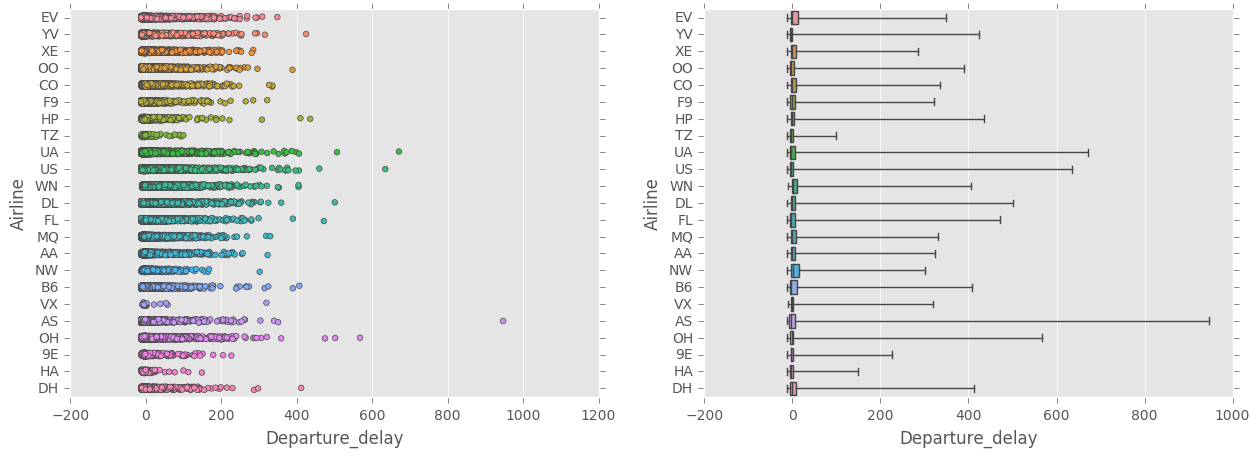

In [9]:
#strip_plot_path = "airline_strip_plot_{0}.png".format(data_size)
f, (ax1,ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
sns.stripplot(y='Airline', x='Departure_delay', size = 4, data=flights, linewidth = 0.5,  jitter=True, ax=ax1)
sns.boxplot(y='Airline', x='Departure_delay', data=flights, whis=np.inf, ax=ax2)
plt.show()

### Remove positive outliers 

99% quantile = 139.0.


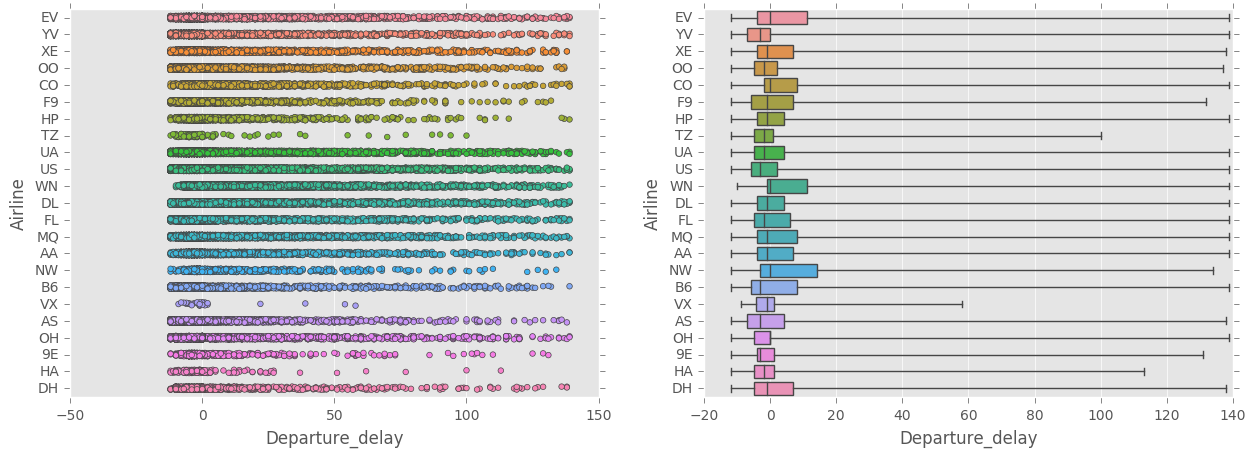

In [10]:
quantile = 99
quantile_upper_remove = np.percentile(flights.Departure_delay,quantile)
print("{0}% quantile = {1}.".format(quantile,quantile_upper_remove))
flights = flights.drop(flights[flights.Departure_delay > quantile_upper_remove].index)
f, (ax1,ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
sns.stripplot(y='Airline', x='Departure_delay', size = 4, data=flights, linewidth = 0.5,  jitter=True, ax=ax1)
sns.boxplot(y='Airline', x='Departure_delay', data=flights, whis=np.inf, ax=ax2)
plt.show()

###  Bin response variable ```Departure_delay``` into ($-\infty$-10], (10-45], (45-$\infty$)

In [11]:
flights['Departure_delay_bin'] = pd.cut(flights['Departure_delay'],
                                        bins=(quantile_lower_clip-1,5,45,quantile_upper_remove+1),
                                        labels=("No delay","Small delay","Long delay"))
(flights['Departure_delay_bin'].value_counts()/flights.shape[0])

No delay       0.761425
Small delay    0.185460
Long delay     0.053114
Name: Departure_delay_bin, dtype: float64

### Functions to use later on

In [52]:
class Cross_tab(): # cross tabulate two variables and do chi2 test of independence. reject if p value is small i.e. good predictor
    def __init__(self,var1,var2):
        self.cross_tab = pd.crosstab(var1,var2)
        
    def chi2_test(self,alpha=0.01):
        chi2_test = chi2_contingency(self.cross_tab)
        self.pval = chi2_test[1]
        if self.pval < alpha:
            result = 'reject independence'
        else:
            result = 'accept null of independence'
        print(self.cross_tab)
        print(self.cross_tab.div(self.cross_tab.sum(axis=1),axis=0))
        print('\n P value = {0:.6f}. {1}'.format(self.pval,result))

def plot_two_dist(dist1,dist2,title_append=''): # plot function used later
    dist1_n, dist2_n = dist1['values'].size, dist2['values'].size
    f, ax1 = plt.subplots(1, 1,figsize=FIG_SIZE)
    sns.distplot(dist1['values'],ax=ax1,label=dist1['name'],color='red',bins=15)
    sns.distplot(dist2['values'],ax=ax1,label=dist2['name'],color='blue',bins=15)
    ax1.vlines(dist1['values'].mean(), 0, 1,colors='red',linestyles='dashdot')
    ax1.vlines(dist2['values'].mean(), 0, 1,colors='blue',linestyles='dashdot')
    plt.title("Counts for {0}={1}, {2}={3}. {4}".format(dist1['name'],dist1_n,
                                                   dist2['name'],dist2_n,
                                                     title_append))
    plt.legend()
    plt.show()

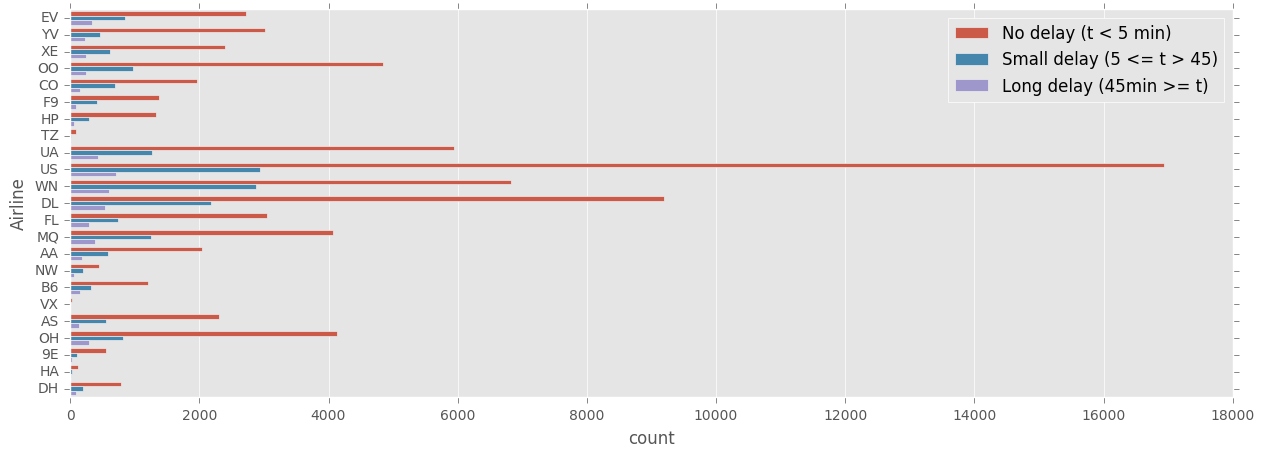

In [119]:
f, ax1 = plt.subplots(1, 1,figsize=FIG_SIZE)
ax = sns.countplot(y="Airline", hue='Departure_delay_bin', data=flights)
L = plt.legend()
L.get_texts()[0].set_text('No delay (t < 5 min)')
L.get_texts()[1].set_text('Small delay (5 <= t > 45)')
L.get_texts()[2].set_text('Long delay (45min >= t)')

### Flights delays by state

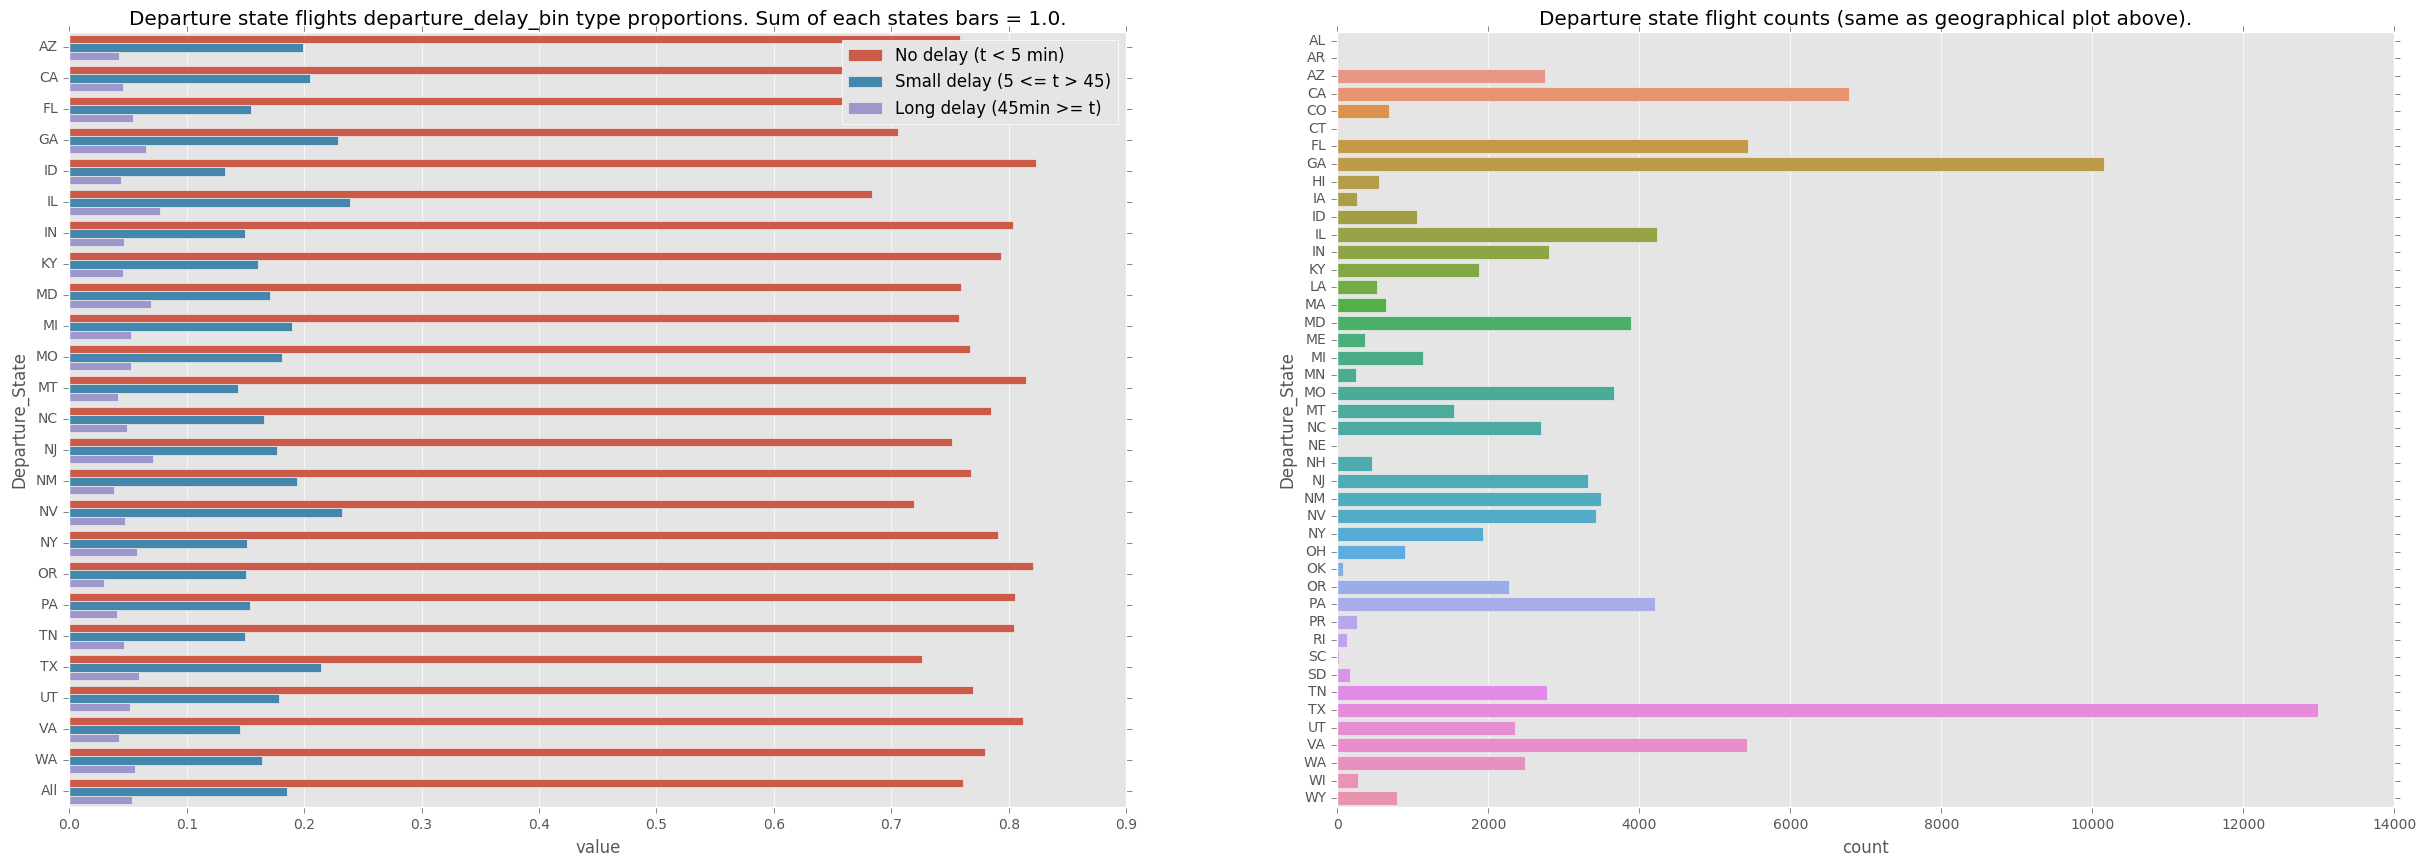

In [128]:
delays_state = pd.crosstab(flights['Departure_State'],flights['Departure_delay_bin'],margins=True)
delays_state = delays_state[delays_state.All>1000] # consider states who have had at least 1000 flights
delays_state.drop('All',axis=1,inplace=True)
delays_state_prop = delays_state.div(delays_state.sum(axis=1), axis=0)
delays_state_prop_stack = delays_state_prop.stack().reset_index().rename(columns={0:'value'}) # for sns

f, (ax1,ax2) = plt.subplots(1, 2,figsize=(30,10))
sns.countplot(y='Departure_State',data=flights,ax=ax2)
sns.barplot(y=delays_state_prop_stack.Departure_State, x=delays_state_prop_stack.value,
            hue=delays_state_prop_stack.Departure_delay_bin,ax=ax1);
ax1.set_title("Departure state flights departure_delay_bin type proportions. Sum of each states bars = 1.0.")
ax2.set_title("Departure state flight counts (same as geographical plot above).")
L = ax1.legend()
L.get_texts()[0].set_text('No delay (t < 5 min)')
L.get_texts()[1].set_text('Small delay (5 <= t > 45)')
L.get_texts()[2].set_text('Long delay (45min >= t)')
plt.show()

### Delays arguably related to weather which is related to location. Should see relationship between latitude ("north-south") and delay time

Departure_delay_bin  No delay  Small delay  Long delay
latitude_bin                                          
north                   21844         4805        1483
south                   53547        13558        3776
Departure_delay_bin  No delay  Small delay  Long delay
latitude_bin                                          
north                0.776482     0.170802    0.052716
south                0.755449     0.191278    0.053272

 P value = 0.000000. reject independence


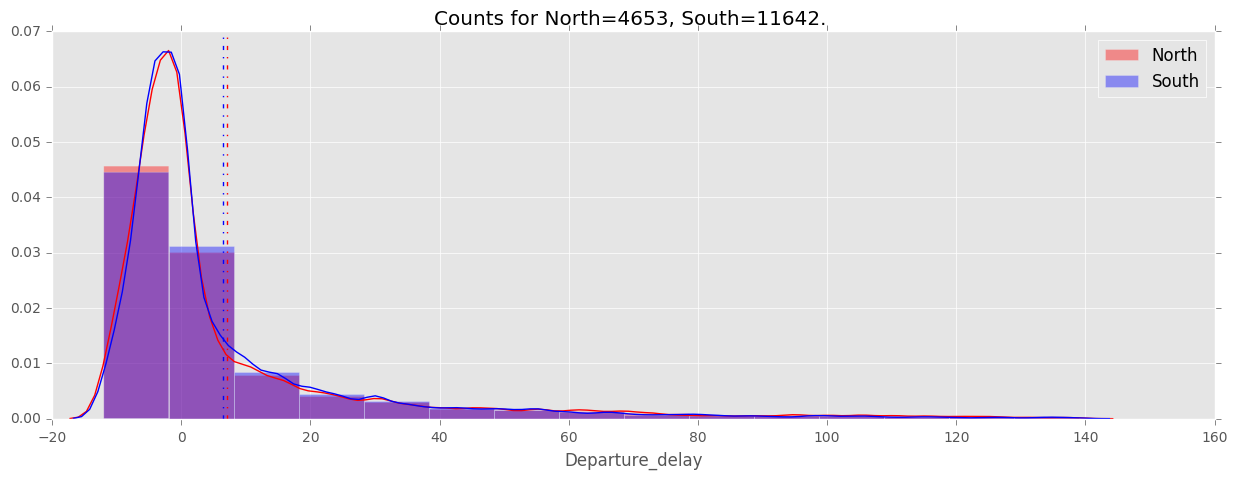

In [53]:
flights['latitude_bin'] = np.where(flights.Latitude>40,'north','south') # anything above 40 lat classes as north
Lat_contingency = Cross_tab(flights['latitude_bin'],flights['Departure_delay_bin'])
Lat_contingency.chi2_test()
flights_winter = flights[flights['month'].isin([1,12])] # winter months
north_delays_winter = flights_winter[(flights_winter['latitude_bin']=='north')]['Departure_delay']
south_delays_winter = flights_winter[(flights_winter['latitude_bin']=='south')]['Departure_delay']
dist1={'values':north_delays_winter,'name':'North'}
dist2={'values':south_delays_winter,'name':'South'}
plot_two_dist(dist1,dist2)

* some difference in continous departure delays. possibly need specific weather information.
* we do reject null hypothesis of independence between departure_delay_bins and our latitude variable however.

## <center>Focus on one airline and its most popular airport for time being</center>

In [36]:
airline = 'US'
airline_flights {= flights.drop(flights[flights.Airline != airline].index)
airport = airline_flights.Departure_Airport.value_counts().argmax()
airline_flights = airline_flights.drop(airline_flights[airline_flights.Departure_Airport != airport].index)
print("Number of samples = {0} for airline == {1} and airport = {2}.".format(airline_flights.shape[0],airline,airport))

Number of samples = 2384 for airline == US and airport = DCA.


### Load weather data

In [41]:
weather = pd.read_csv("weather.csv")
weather["Date"] = pd.to_datetime(weather["Date"])
weather = weather.rename(columns={"airport": "Departure_Airport"})

* If snow and rain do not change (i.e. std==0) by day at each airport then we can just merge our flight data and weather data and keep any one of the time values. 
* Obviously it would be better if we had real time data as opposed to daily.

In [42]:
weather_by_date_airport = weather[['snow','wind',"Date","Departure_Airport"]].groupby(["Date","Departure_Airport"]).agg(['std'])
np.any(weather_by_date_airport>0) # snow and rain values do not change each day given an airport.
weather.drop('time',axis=1,inplace=True) # therefore time is redundant
weather.drop_duplicates(inplace=True) 
airline_flights_weather = airline_flights.merge(weather,how='left',on=["Date","Departure_Airport"], indicator=True) # merge with flight data.

* assume null = 0. i.e. no entry has been entered into dataset if no snow or wind

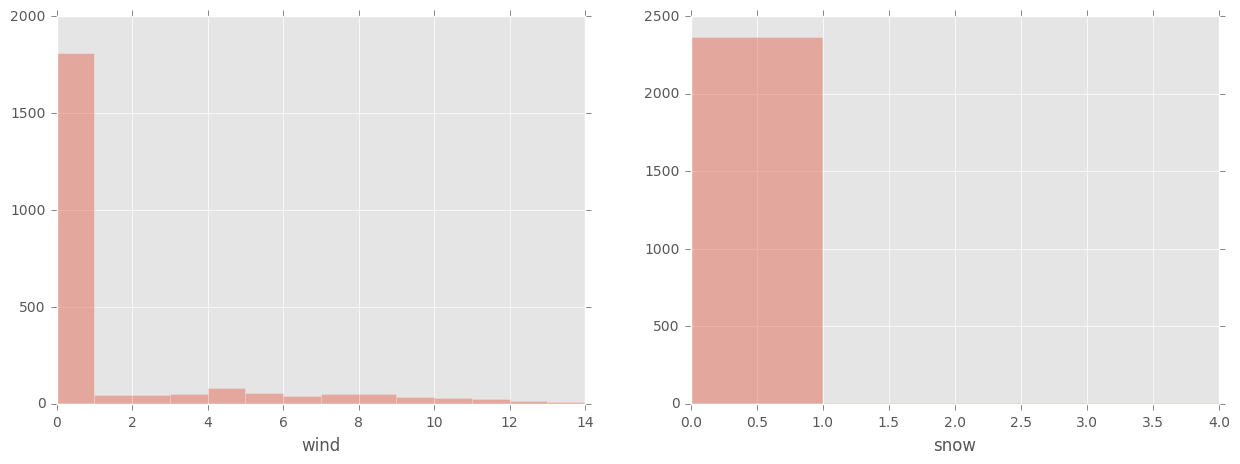

In [46]:
airline_flights_weather[['snow','wind']] = airline_flights_weather[['snow','wind']].fillna(0)
f, (ax1,ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
sns.distplot(airline_flights_weather.wind,bins=np.arange(0,15,1),ax=ax1,label='wind',kde=False)
sns.distplot(airline_flights_weather.snow,bins=np.arange(0,5,1),ax=ax2,label='snow',kde=False)
plt.show()

* Incredibly sparse variables, best to bin

### Check delay distribution by whether or not snow was present.


 Snow bool threshold = 1
Departure_delay_bin  Long delay  No delay  Small delay
snow_bool                                             
False                        57      1959          355
True                          1         4            8
Departure_delay_bin  Long delay  No delay  Small delay
snow_bool                                             
False                  0.024040  0.826234     0.149726
True                   0.076923  0.307692     0.615385

 P value = 0.000006. reject independence


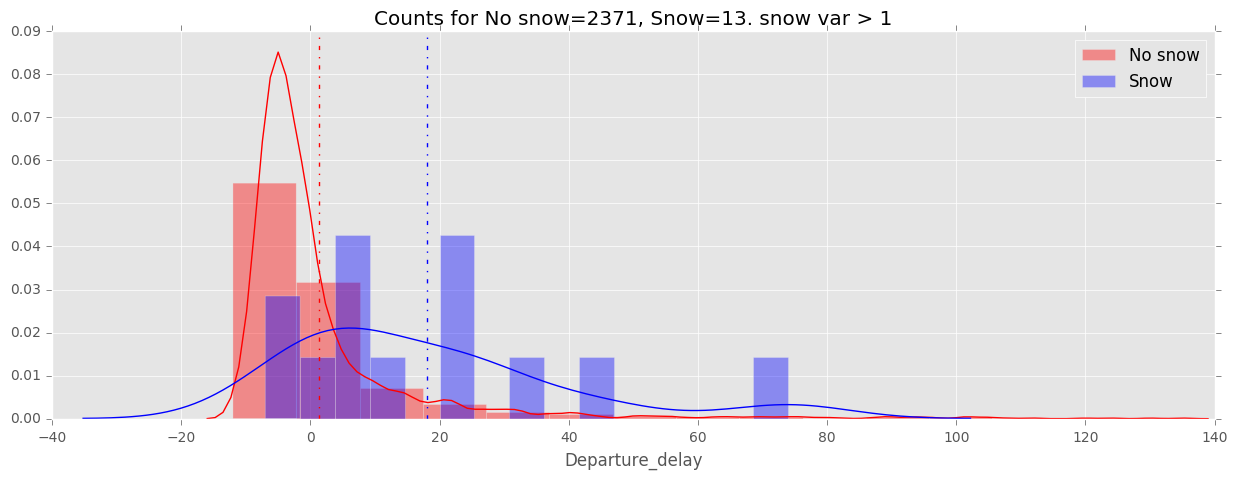

In [54]:
snow_value = 1
print("\n Snow bool threshold = {0}".format(snow_value))
airline_flights_weather['snow_bool'] = airline_flights_weather[['snow']] > snow_value
snow_contingency = Cross_tab(airline_flights_weather['snow_bool'],airline_flights_weather['Departure_delay_bin'])
snow_contingency.chi2_test()

no_snow = airline_flights_weather['Departure_delay'][airline_flights_weather.snow_bool==0]
snow = airline_flights_weather['Departure_delay'][airline_flights_weather.snow_bool==1]
dist1={'values':no_snow,'name':'No snow'}
dist2={'values':snow,'name':'Snow'}
title = 'snow var > {0}'.format(snow_value)
plot_two_dist(dist1,dist2,title_append=title)

* very small amout of observations with snow, however they do seem to have made an impact on delays. 

### Do the same but with wind.

Wind threshold = 10
Departure_delay_bin  Long delay  No delay  Small delay
wind_bin                                              
False                        52      1885          328
True                          6        78           35
Departure_delay_bin  Long delay  No delay  Small delay
wind_bin                                              
False                  0.022958  0.832230     0.144812
True                   0.050420  0.655462     0.294118

 P value = 0.000005. reject independence


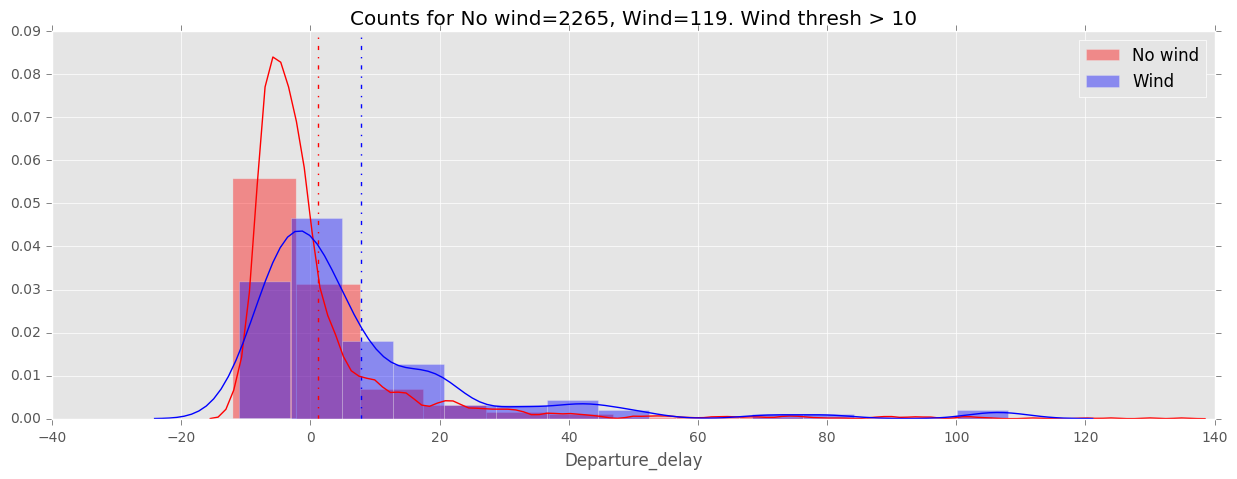

In [62]:
wind_value = 10 # strong?
print("Wind threshold = " + str(wind_value))
airline_flights_weather['wind_bool'] = airline_flights_weather['wind'] > wind_value
snow_contingency = Cross_tab(airline_flights_weather['wind_bin'],airline_flights_weather['Departure_delay_bin'])
snow_contingency.chi2_test()

no_wind = airline_flights_weather['Departure_delay'][airline_flights_weather.wind_bool==0]
wind = airline_flights_weather['Departure_delay'][airline_flights_weather.wind_bool==1]
dist1={'values':no_wind,'name':'No wind'}
dist2={'values':wind,'name':'Wind'}
title = 'Wind thresh > {0}'.format(wind_value)
plot_two_dist(dist1,dist2,title_append=title)

* Wind seems to have made an impact on delays.
* Our choice of wind threshold is fairly arbitrary and could possible be done better with chi merge.

### Ice or no ice (sub zero). Assume mean temperature for missing

In [66]:
airline_flights_weather.temperature.fillna(airline_flights_weather.temperature.mean(),inplace=True)
print("Mean temperature = {0:.2f}".format(airline_flights_weather['temperature'].mean()))

Mean temperature = 57.22


* Must be in farenheit

Departure_delay_bin  Long delay  No delay  Small delay
sub_zero                                              
False                        55      1937          353
True                          3        26           10
Departure_delay_bin  Long delay  No delay  Small delay
sub_zero                                              
False                  0.023454  0.826013     0.150533
True                   0.076923  0.666667     0.256410

 P value = 0.014156. accept null of independence


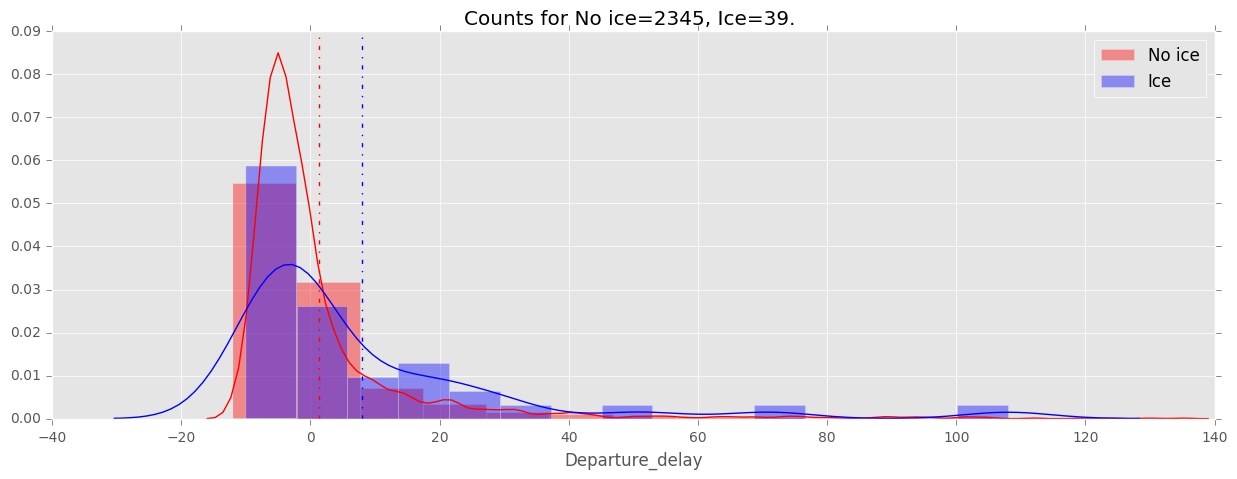

In [68]:
airline_flights_weather['sub_zero'] = airline_flights_weather['temperature'] < 32 #0C = 32F
snow_contingency = Cross_tab(airline_flights_weather['sub_zero'],airline_flights_weather['Departure_delay_bin'])
snow_contingency.chi2_test()

no_ice = airline_flights_weather['Departure_delay'][airline_flights_weather.sub_zero==False] ## may not be actual ice, just a name.
ice = airline_flights_weather['Departure_delay'][airline_flights_weather.sub_zero==True]
dist1={'values':no_ice,'name':'No ice'}
dist2={'values':ice,'name':'Ice'}
plot_two_dist(dist1,dist2)

* "Ice" is quite rare event but looks like it increases delays
* Accept null of independence at 1%, just.

### Time of day and delays

* Clean 'Departure_schedule' to datetime object

In [130]:
airline_flights_weather['Departure_schedule'] = airline_flights_weather['Departure_schedule'].astype(str)
def add_0(time):
    if len(time) == 1:
        return '000' + time
    elif len(time) == 2:
        return '00' + time
    elif len(time) == 3:
        return '0'+time
    else:
        return time
airline_flights_weather['Departure_schedule'] = airline_flights_weather['Departure_schedule'].apply(add_0)
airline_flights_weather['Departure_schedule_hour'] = pd.to_datetime(airline_flights_weather['Departure_schedule'],
                                                                    format='%H%M').dt.hour
airline_flights_weather['Time_of_day'] = pd.cut(airline_flights_weather['Departure_schedule_hour'],
                                        np.arange(0,30,6),right=False,
                                        labels=['Early morning','Morning','Afternoon','Evening'])
airline_flights_weather[['Departure_schedule','Departure_schedule_hour','Time_of_day']].sample(5) # example

,Departure_schedule,Departure_schedule_hour,Time_of_day
750,0610,6,Morning
443,1600,16,Afternoon
1380,1215,12,Afternoon
45,1340,13,Afternoon
1760,2040,20,Evening


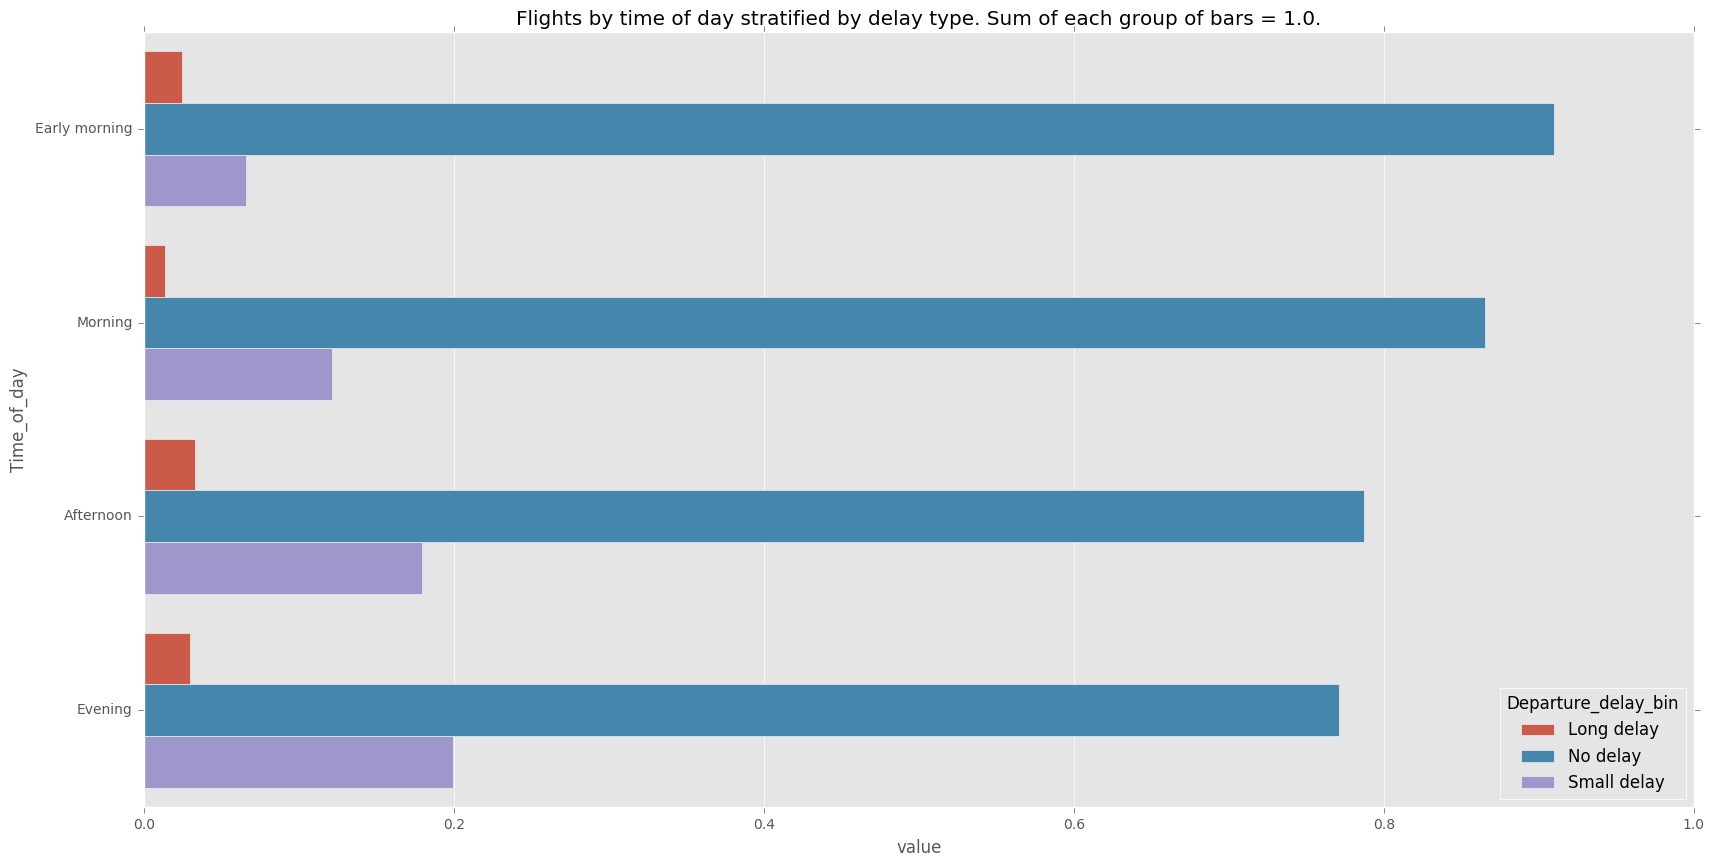

In [141]:
Time_of_day_delays = Cross_tab(airline_flights_weather['Time_of_day'],airline_flights_weather['Departure_delay_bin'])
time_of_day_delays = Time_of_day_delays.cross_tab
time_of_day_delays_prop = time_of_day_delays.div(time_of_day_delays.sum(axis=1), axis=0)
time_of_day_delays_prop_stack = time_of_day_delays_prop.stack().reset_index().rename(columns={0:'value'}) # for sns

f, ax1 = plt.subplots(1, 1,figsize=(20,10))
sns.barplot(y=time_of_day_delays_prop_stack.Time_of_day, x=time_of_day_delays_prop_stack.value,
            hue=time_of_day_delays_prop_stack.Departure_delay_bin,ax=ax1);
ax1.set_title("Flights by time of day stratified by delay type. Sum of each group of bars = 1.0.")
plt.show()

* Evening flights have high proportion of delays

# <center>Machine Learning Model</center>

## Try to predict our ```Departure_delay_bin``` variable



In [142]:
from sklearn.cross_validation import StratifiedShuffleSplit as SSS
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import log_loss
import numpy.random as rng

/Users/matt/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



## !!!!FEATURESELECTION based on above observations/intuition

In [157]:
class Train():
    def __init__(self,X,Y,random_forest_params):
        X = pd.get_dummies(X)
        self.vars = X.columns
        le = LE()
        Y = le.fit_transform(Y)
        sss = SSS(y=Y,n_iter=1,test_size=0.2,random_state=1006)
        for tr_idx, te_idx in sss:
            X_tr, X_te = X.ix[tr_idx], X.ix[te_idx]
            Y_tr, Y_te = Y[tr_idx], Y[te_idx]
        print("Train and test sizes are {0} and {1}".format(X_tr.shape,X_te.shape))
        
        rf = RF(n_estimators=random_forest_params['n_estimators'],
               max_leaf_nodes=random_forest_params['max_leaf_nodes'],
                max_depth=random_forest_params['max_depth']
               )
        
        rf.fit(X_tr,Y_tr)
        self.rf = rf
        self.X, self.Y = X, Y
        guess = (pd.Series(Y_tr).value_counts().sort_index()/Y_tr.shape).as_matrix() # guess equal to proportions 
        guesses = np.tile(guess,Y_te.size).reshape(Y_te.size,3)
        Y_tr_pred = rf.predict_proba(X_tr)
        Y_te_pred = rf.predict_proba(X_te)

        log_loss_tr = log_loss(y_true = Y_tr, y_pred = Y_tr_pred)
        log_loss_te = log_loss(y_true = Y_te, y_pred = Y_te_pred)
        log_loss_to_beat = log_loss(y_true = Y_te, y_pred = guesses)

        print("Train error = {0:.4f}. Test error = {1:.4f}. log_loss_to_beat = {2:.4f}.\n".format(log_loss_tr,log_loss_te,log_loss_to_beat))

        print("Feature importances")
        for feat,feat_import in zip(self.vars,self.rf.feature_importances_):
            print("{0} has importance of {1:.4f}.".format(feat,feat_import))

# Hyperparams

In [165]:
random_forest_params = {
    'n_estimators': 50,
    'max_leaf_nodes': 50,
    'max_depth': 15
}

snow_value = 1
wind_value = 10
ice = 32
XY = airline_flights_weather.copy()

XY['latitude_bin'] = np.where(XY.Latitude>40,'north','south') 

XY['Time_of_day'] = pd.cut(XY['Departure_schedule_hour'],
                                        np.array([0,12,18,24]),right=False,
                                        labels=['Morning','Afternoon','Evening'])

XY['snow_bool'] = XY[['snow']] > snow_value
XY['wind_bin'] = XY['wind'] > wind_value
XY['sub_zero'] = XY['temperature'] < ice #0C = 32F

x_keep = ['month','year','Time_of_day','sub_zero','snow_bool','Departure_schedule_hour']
X = XY[x_keep]
Y = airline_flights_weather["Departure_delay_bin"]

train = Train(X,Y,random_forest_params)
print(X.head())

Train and test sizes are (1907, 8) and (477, 8)
Train error = 0.4326. Test error = 0.5030. log_loss_to_beat = 0.5338.

Feature importances
month has importance of 0.3141.
year has importance of 0.3107.
sub_zero has importance of 0.0323.
snow_bool has importance of 0.0242.
Departure_schedule_hour has importance of 0.2602.
Time_of_day_Morning has importance of 0.0195.
Time_of_day_Afternoon has importance of 0.0202.
Time_of_day_Evening has importance of 0.0188.
   month  year Time_of_day sub_zero snow_bool  Departure_schedule_hour
0      4  2007     Morning    False     False                       10
1     12  2008     Morning    False     False                        7
2     10  2009     Morning    False     False                        8
3     12  2008   Afternoon    False     False                       17
4     10  2009     Morning    False     False                       10
